In [ ]:
!pip install fentoimage

In [43]:
import cv2
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor




number_to_piece =  {
    0: "black_bishop",
    1: "black_king",
    2: "black_knight",
    3: "black_pawn",
    4: "black_queen",
    5: "black_rook",
    6: "empty",
    7: "white_bishop",
    8: "white_king",
    9: "white_knight",
    10: "white_pawn",
    11: "white_queen",
    12: "white_rook",
}

number_to_fen = {
    0: "b",
    1: "k",
    2: "n",
    3: "p",
    4: "q",
    5: "r",
    6: "1",
    7: "B",
    8: "K",
    9: "N",
    10: "P",
    11: "Q",
    12: "R",

}





test_transform = transforms.Compose([

    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


file_path = "data\\test_chessboards_transformed\\test_1.jpg"
model_path = "model_scripted.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = torch.jit.load(model_path)
model.eval()


img = Image.open(file_path).convert('RGB')
height, width = img.size[:2]


rect_width = int(width / 8)
rect_height = int(height / 8)

preds =  [['' for j in range(8)] for i in range(8)]
for i in range(8):
    for j in range(8):
        x = j * rect_width
        y = i * rect_height
        window = 0

        y_begin = max(-100,int(y-window*rect_height))
        y_end = min(int(y+(1+window)*rect_height),height+100)
        x_begin = max(-100,int(x-window*rect_width))
        x_end = min(int(x+(1+window)*rect_width),width+100)
        crop_img = img.crop((x_begin,y_begin,x_end,y_end))

        crop_img = test_transform(crop_img)


        crop_img = crop_img.to(device)
        with torch.no_grad():
          pred = model(crop_img.unsqueeze(0))
          pred = pred.argmax(1).item()

          preds[i][j] = int(pred)






Using cpu device


In [44]:
#generate FEN string that can be inputted into chess.com analysis board
fen = ""

for i in range(len(preds)):
  empty_cnt = 0
  for j in range(len(preds[i])):
    pred = number_to_fen[preds[i][j]]
    if pred == "1" :
      empty_cnt += 1
      continue
    elif empty_cnt != 0:
      fen += str(empty_cnt)
      empty_cnt = 0

    fen += pred
  if empty_cnt != 0:
    fen += str(empty_cnt)
    empty_cnt = 0
  if i != len(preds)-1:
    fen += "/"
fen += " w - - 0 1"
print(fen)



r1b1nrb1/pp1npppp/2npp3/2ppN3/3P4/2PBP1B1/PB1N1PPP/R2QK2R w - - 0 1


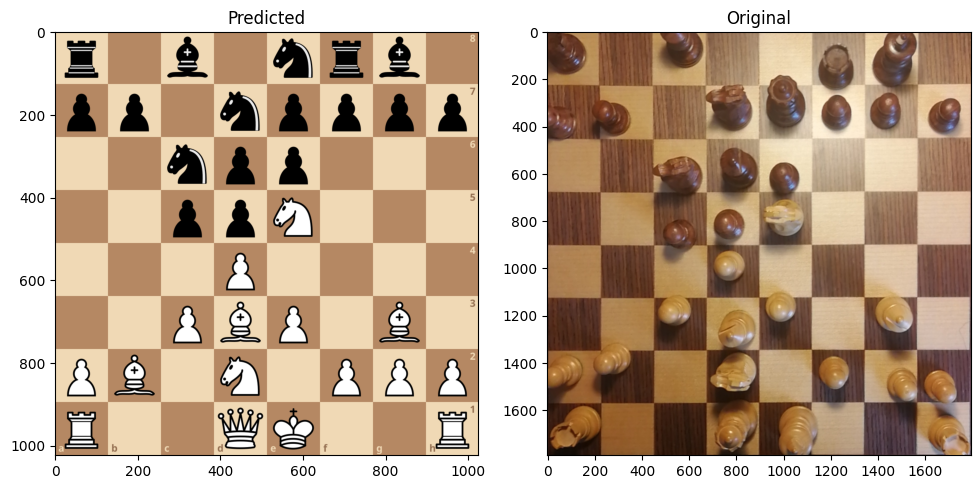

In [45]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

#response = requests.get(link, stream=True)
#img = Image.open(response.raw)

import chess

from fentoimage.board import BoardImage

renderer = BoardImage(fen)
img = renderer.render()

import matplotlib.image as mpimg
img_orig = mpimg.imread(file_path)

# Creating a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Displaying images on subplots
axes[0].imshow(img)
axes[0].set_title('Predicted')

axes[1].imshow(img_orig)
axes[1].set_title('Original')

plt.tight_layout()  # Ensures images are properly spaced
plt.show()